In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.helpers import data_identifier, console_bold, present_float

In [3]:
name = "Rabi RF Multiple Flop Times"
analysis_number = None
identifier = None

In [4]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

In [143]:
data_numbers = [422]
data, headers = get_experiment_data(data_numbers[0])
identifier = "data " + data_identifier(data_numbers) + ", analysis " + data_identifier([analysis_number])

In [144]:
if input(f"Create new analysis folder? (y/{console_bold('n')}) ") == "y":
    analysis_number = open_analysis_folder(name)
else:
    if input(f"Keep current analysis number of {analysis_number}? ({console_bold('y')}/n) ") == "n":
        analysis_number = int(input("Enter analysis number: "))
identifier = "data " + data_identifier(data_numbers) + ", analysis " + data_identifier([analysis_number])
print(f"Current analysis number is {analysis_number}")

Create new analysis folder? (y/n)  y


Current analysis number is 309


In [145]:
average_scans = False
all_scans = True
if input(f"Plot average Scans? (y/{console_bold('n')}) ") == "y":
    average_scans = True
if input(f"Plot all scans? (y/{console_bold('n')}) ") == "n":
    all_scans = False

Plot average Scans? (y/n)  y
Plot all scans? (y/n)  y


In [146]:
probe_detunings = headers["params"]["probe_detunings"].to("MHz").magnitude
probe_start_times = np.arange(len(probe_detunings)) * (headers["params"]["probe_on_time"] + headers["params"]["probe_off_time"]) + headers["params"]["ttl_probe_offset_time"]
probe_end_times = probe_start_times + headers["params"]["probe_off_time"]
probe_start_times = probe_start_times.to("s").magnitude + 5e-6
probe_end_times = probe_end_times.to("s").magnitude + 4e-6

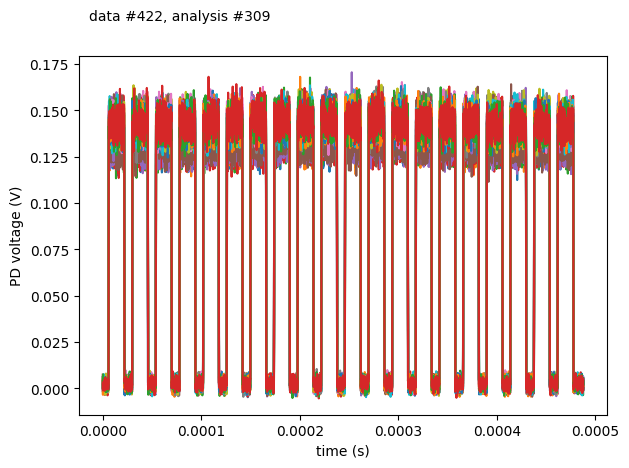

In [147]:
fig, ax = plt.subplots()
add_label(ax)
ax.plot(data["total_experiment_times"][0], np.transpose(data["total_experiment_voltages"][0]))
#ax.vlines(probe_start_times, 0, 0.08, color="k")
#ax.vlines(probe_end_times, 0, 0.08, color="k")
ax.set_xlabel("time (s)")
ax.set_ylabel("PD voltage (V)")
plt.tight_layout()
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "all_data.pdf"))
plt.show()

In [148]:
num_runs = len(headers["params"]['flop_times'])
voltage_data = dict.fromkeys(headers["params"]['flop_times'])
voltage_err_data = dict.fromkeys(headers["params"]['flop_times'])
for jj in range(num_runs):
    voltages_run = {
        "initial": [],
        "post_burn": [],
        "post_pump": [],
        "post_flop": [],
    }
    voltages_err_run = {
        "initial": [],
        "post_burn": [],
        "post_pump": [],
        "post_flop": [],
    }
    for ll in range(4):
        if ll == 0:
            label = "initial"
        elif ll == 1:
            label = "post_burn"
        elif ll == 2:
            label = "post_pump"
        elif ll == 3:
            label = "post_flop"
        for mm in range(headers["params"]["probe_repeats"]):
            run = []
            run_err = []
            index = ll * headers["params"]["probe_repeats"] + mm
            for kk in range(len(probe_detunings)):
                start = probe_start_times[kk]
                end = probe_end_times[kk]
                mask = np.bitwise_and(data["total_experiment_times"][jj] > start, data["total_experiment_times"][jj] <= end)
                avg = np.average(data["total_experiment_voltages"][jj][index][mask])
                try:
                    ste = np.std(data["total_experiment_voltages"][jj][index][mask]) / np.sqrt(len(data["total_experiment_voltages"][jj][index][mask] - 1))
                except ZeroDivisionError:
                    ste = np.nan
                run.append(avg)
                run_err.append(ste)
            voltages_run[label].append(run)
            voltages_err_run[label].append(run_err)

    voltage_data[headers["params"]["flop_times"][jj]]= voltages_run
    voltage_err_data[headers["params"]["flop_times"][jj]] = voltages_err_run


In [149]:
flop_time = headers["params"]['flop_times'][0]

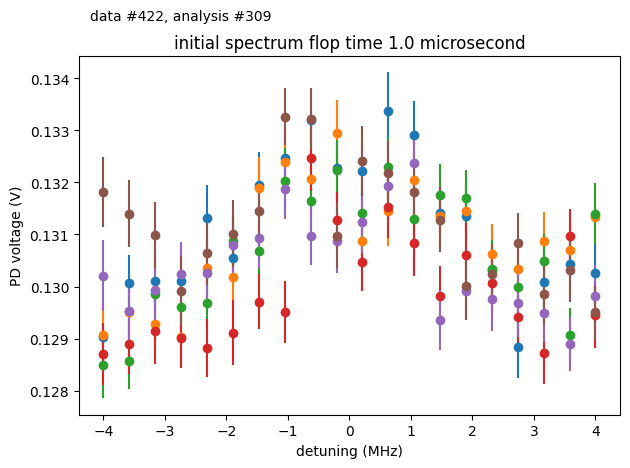

In [150]:
if all_scans:
    fig, ax = plt.subplots()
    add_label(ax)
    label = "initial"
    for kk in range(headers["params"]["probe_repeats"]):
        ax.errorbar(probe_detunings, voltage_data[flop_time][label][kk], voltage_err_data[flop_time][label][kk], fmt="o", ls="none")
    ax.set_xlabel("detuning (MHz)")
    ax.set_ylabel("PD voltage (V)")
    ax.set_title(f"{label} spectrum flop time {flop_time}")
    plt.tight_layout()
    plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + f"{label}.pdf"))
    plt.show()

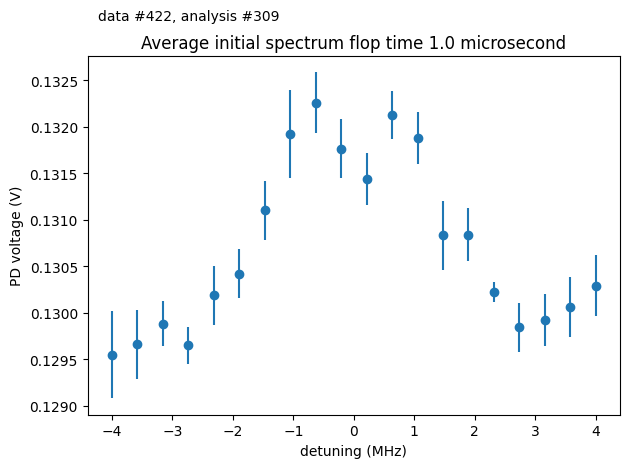

In [151]:
if average_scans:
    fig, ax = plt.subplots()
    add_label(ax)
    label = "initial"
    avg_y = []
    avg_err = []
    for kk in range(len(voltage_data[flop_time][label][0])):
        y_values = [voltage_data[flop_time][label][jj][kk] for jj in range(headers["params"]["probe_repeats"])]
        avg_y.append(np.average(y_values))
        avg_err.append(np.std(y_values) / np.sqrt(headers["params"]["probe_repeats"]))
    
    ax.errorbar(probe_detunings, avg_y,yerr = avg_err, fmt="o", ls="none")
    ax.set_xlabel("detuning (MHz)")
    ax.set_ylabel("PD voltage (V)")
    ax.set_title(f"Average {label} spectrum flop time {flop_time}")
    plt.tight_layout()
    plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + f"{label}.pdf"))
    plt.show()

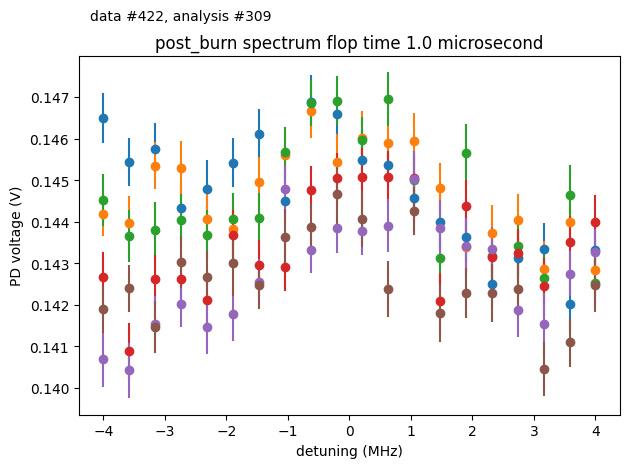

In [152]:
if all_scans:
    fig, ax = plt.subplots()
    add_label(ax)
    label = "post_burn"
    for kk in range(headers["params"]["probe_repeats"]):
        ax.errorbar(probe_detunings, voltage_data[flop_time][label][kk], voltage_err_data[flop_time][label][kk], fmt="o", ls="none")
    ax.set_xlabel("detuning (MHz)")
    ax.set_ylabel("PD voltage (V)")
    ax.set_title(f"{label} spectrum flop time {flop_time}")
    plt.tight_layout()
    plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + f"{label}.pdf"))
    plt.show()

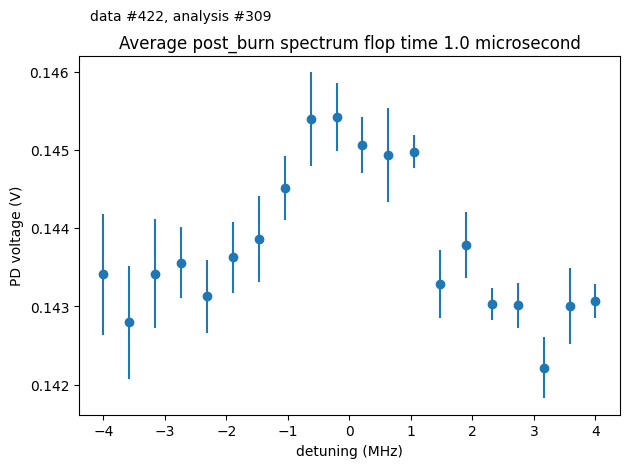

In [153]:
if average_scans:
    fig, ax = plt.subplots()
    add_label(ax)
    label = "post_burn"
    avg_y = []
    avg_err = []
    for kk in range(len(voltage_data[flop_time][label][0])):
        y_values = [voltage_data[flop_time][label][jj][kk] for jj in range(headers["params"]["probe_repeats"])]
        avg_y.append(np.average(y_values))
        avg_err.append(np.std(y_values) / np.sqrt(headers["params"]["probe_repeats"]))
    
    ax.errorbar(probe_detunings, avg_y,yerr = avg_err, fmt="o", ls="none")
    ax.set_xlabel("detuning (MHz)")
    ax.set_ylabel("PD voltage (V)")
    ax.set_title(f"Average {label} spectrum flop time {flop_time}")
    plt.tight_layout()
    plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + f"{label}.pdf"))
    plt.show()

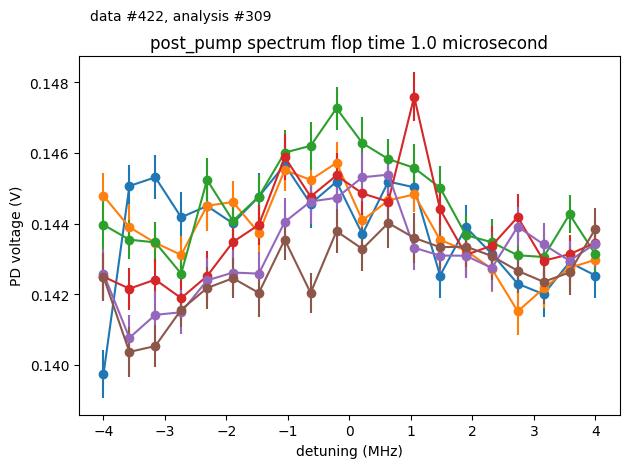

In [154]:
if all_scans: 
    fig, ax = plt.subplots()
    add_label(ax)
    label = "post_pump"
    for kk in range(headers["params"]["probe_repeats"]):
        ax.errorbar(probe_detunings, voltage_data[flop_time][label][kk], voltage_err_data[flop_time][label][kk], fmt="o", ls="-")
    ax.set_xlabel("detuning (MHz)")
    ax.set_ylabel("PD voltage (V)")
    ax.set_title(f"{label} spectrum flop time {flop_time}")
    plt.tight_layout()
    plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + f"{label}.pdf"))
    plt.show()

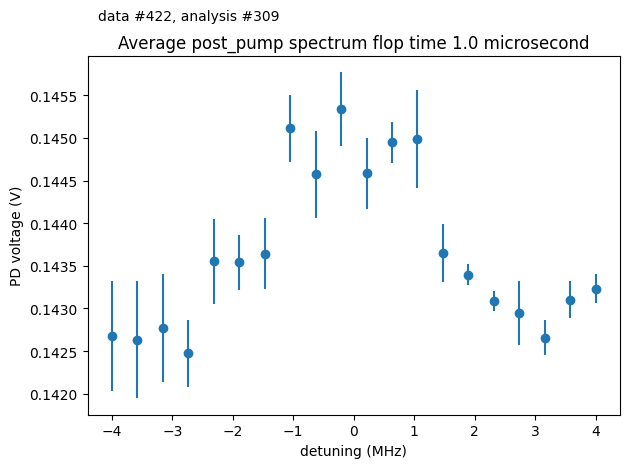

In [155]:
if average_scans:
    fig, ax = plt.subplots()
    add_label(ax)
    label = "post_pump"
    avg_y = []
    avg_err = []
    for kk in range(len(voltage_data[flop_time][label][0])):
        y_values = [voltage_data[flop_time][label][jj][kk] for jj in range(headers["params"]["probe_repeats"])]
        avg_y.append(np.average(y_values))
        avg_err.append(np.std(y_values) / np.sqrt(headers["params"]["probe_repeats"]))
    
    ax.errorbar(probe_detunings, avg_y,yerr = avg_err, fmt="o", ls="none")
    ax.set_xlabel("detuning (MHz)")
    ax.set_ylabel("PD voltage (V)")
    ax.set_title(f"Average {label} spectrum flop time {flop_time}")
    plt.tight_layout()
    plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + f"{label}.pdf"))
    plt.show()

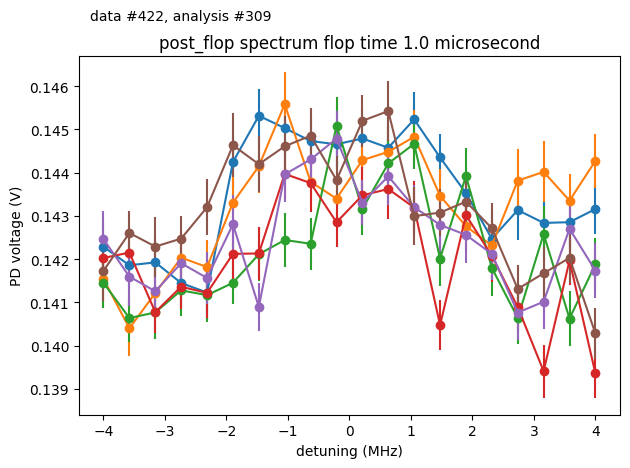

In [156]:
if all_scans:
    fig, ax = plt.subplots()
    add_label(ax)
    label = "post_flop"
    for kk in range(headers["params"]["probe_repeats"]):
        ax.errorbar(probe_detunings, voltage_data[flop_time][label][kk], voltage_err_data[flop_time][label][kk], fmt="o", ls="-")
    ax.set_xlabel("detuning (MHz)")
    ax.set_ylabel("PD voltage (V)")
    ax.set_title(f"{label} spectrum flop time {flop_time}")
    plt.tight_layout()
    plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + f"{label}.pdf"))
    plt.show()

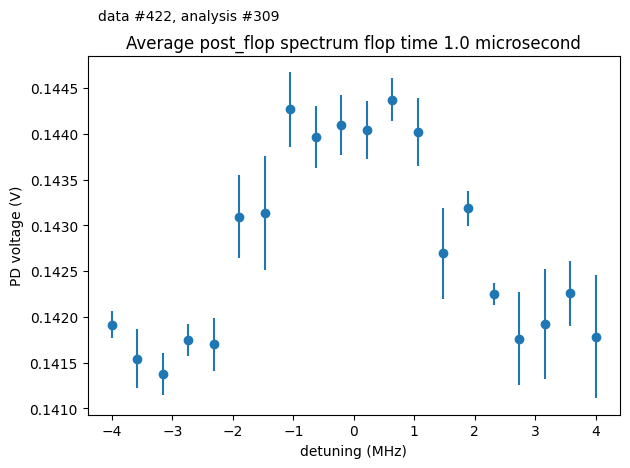

In [157]:
if average_scans:
    fig, ax = plt.subplots()
    add_label(ax)
    label = "post_flop"
    avg_y = []
    avg_err = []
    for kk in range(len(voltage_data[flop_time][label][0])):
        y_values = [voltage_data[flop_time][label][jj][kk] for jj in range(headers["params"]["probe_repeats"])]
        avg_y.append(np.average(y_values))
        avg_err.append(np.std(y_values) / np.sqrt(headers["params"]["probe_repeats"]))
    
    ax.errorbar(probe_detunings, avg_y,yerr = avg_err, fmt="o", ls="none")
    ax.set_xlabel("detuning (MHz)")
    ax.set_ylabel("PD voltage (V)")
    ax.set_title(f"Average {label} spectrum flop time {flop_time}")
    plt.tight_layout()
    plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + f"{label}.pdf"))
    plt.show()

NameError: name 'voltages' is not defined

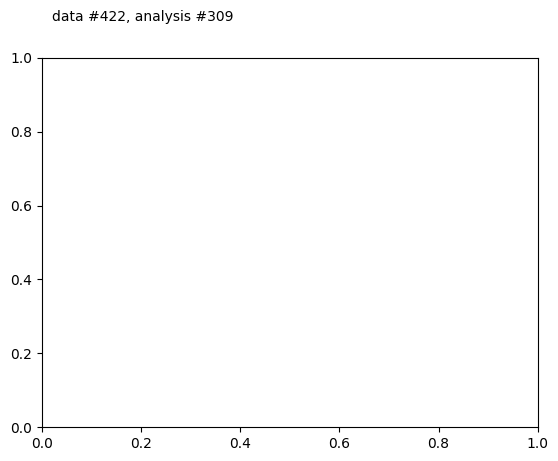

In [158]:
fig, ax = plt.subplots()
add_label(ax)
label = "initial"
for kk in range(headers["params"]["probe_repeats"]):
    if kk == 0:
        ax.errorbar(probe_detunings, voltages["initial"][kk], voltages_err["initial"][kk], fmt="o", ls="none", color="C0", label="initial")
        ax.errorbar(probe_detunings, voltages["post_burn"][kk], voltages_err["post_burn"][kk], fmt="o", ls="none", color="C1", label="post_burn")
        ax.errorbar(probe_detunings, voltages["post_pump"][kk], voltages_err["post_pump"][kk], fmt="o", ls="none", color="C2", label="post_pump")
        ax.errorbar(probe_detunings, voltages["post_flop"][kk], voltages_err["post_flop"][kk], fmt="o", ls="none", color="C3", label="post_flop")
    else:
        ax.errorbar(probe_detunings, voltages["initial"][kk], voltages_err["initial"][kk], fmt="o", ls="none", color="C0")
        ax.errorbar(probe_detunings, voltages["post_burn"][kk], voltages_err["post_burn"][kk], fmt="o", ls="none", color="C1")
        ax.errorbar(probe_detunings, voltages["post_pump"][kk], voltages_err["post_pump"][kk], fmt="o", ls="none", color="C2")
        ax.errorbar(probe_detunings, voltages["post_flop"][kk], voltages_err["post_flop"][kk], fmt="o", ls="none", color="C3")
ax.set_xlabel("detuning (MHz)")
ax.set_ylabel("PD voltage (V)")
ax.legend()
ax.set_title("Comparison")
plt.tight_layout()
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "comparison.pdf"))
plt.show()